# Light Ale, Big Fail: What Beer Reviewers Hate the Most

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from src.utils import tqdm
from src.data_loading import iter_reviews, load_beers_breweries_users, data_load
from src.data_processing import add_review_columns, build_corpus
from src.text_processing import get_stop_words, get_word_counts, get_tfidf_scores, get_top_attributes, Lemmatizer, Stemmer
import langid
from gensim import models
from src.text_processing import top_attributes_by
from src.text_processing import classify_beer_attributes
import seaborn as sn

In [2]:
import nltk

nltk.download("all", quiet=True)

True

## Introduction and motivation

## Data pre-processing

#### Milestone 2 processing

In [3]:
# TODO upload data

# NOTE instead of running the code below which will process the data and might take a bit of time,
# use the link below to download all the data needed
# https://drive.google.com/file/d/1GYsJh6MTX53RXv2qWh-G7FDmyi2JIZKz/view?usp=sharing

In [4]:
raw_directory = "./data/RateBeer/"
processed_directory = "./data/RateBeer_processed/"

if os.path.exists(processed_directory):
    beers = pd.read_csv(processed_directory + "beers.csv")
    breweries = pd.read_csv(processed_directory + "breweries.csv")
    users = pd.read_csv(processed_directory + "users.csv")

else:
    os.makedirs(processed_directory)

    beers, breweries, users = load_beers_breweries_users(raw_directory)
    beers = add_review_columns(raw_directory + "reviews.txt", beers, by="beer_id")
    users = add_review_columns(raw_directory + "reviews.txt", users, by="user_id")
    users = users[~users.duplicated(subset='user_id', keep=False)]

    drop_columns = [
        "overall_score", "style_score", "zscore", "nbr_matched_valid_ratings", "avg_matched_valid_ratings"
    ]
    beers = beers.drop(columns=drop_columns)

    #beers["beer_id"] = beers["beer_id"].astype("string")

    beers.to_csv(processed_directory + "beers.csv", index=False)
    breweries.to_csv(processed_directory + "breweries.csv", index=False)
    users.to_csv(processed_directory + "users.csv", index=False)

In [5]:
unique_beers = len(beers["beer_id"].unique())
unique_styles = len(beers["style"].unique())
unique_users = len(users["user_id"].unique())
unique_countries = len(breweries[~breweries["location"].str.startswith("United States")]["location"].unique()) + 1
unique_beers, unique_styles, unique_users, unique_countries

(396690, 93, 70112, 217)

#### Reviews language

In [6]:
threshold = 300
reviews_csv_path = processed_directory + "popular_beers_reviews.csv"

if os.path.exists(reviews_csv_path):
    reviews = pd.read_csv(reviews_csv_path)

else:
    popular_beers = beers[beers["review_count"] > threshold]
    popular_beers_id = list(popular_beers["beer_id"])
    
    reviews = [r for r in iter_reviews(raw_directory + "reviews.txt", do_cast=True)
               if r["beer_id"] in popular_beers_id]

    # non-english reviews have encoding issues and unique words that may bias our analysis (eg tf-idf)
    for review in tqdm(reviews):
        language, _ = langid.classify(review["text"])
        review["language"] = language

    reviews = pd.DataFrame(reviews)
    reviews.to_csv(reviews_csv_path, index=False)

non_english = len(reviews[reviews["language"] != "en"])
print(f"{100 * (non_english / len(reviews)):.1f}% non-english reviews")

beers_count = len(reviews["beer_id"].value_counts())
print(f"{beers_count} beers with more than {threshold} reviews ({len(reviews)} reviews in total)")

5.5% non-english reviews
3185 beers with more than 300 reviews (2271818 reviews in total)


## Extracting features from beers

#### Finding the experts

In [7]:
# example beer reviews for canadian beer "Dieu du Ciel Aphrodisiaque"
levels = ["Beginner", "Expert  ", "Expert  "]
expert_vs_beginner_reviews = reviews.loc[[29575, 29428, 29429]]["text"].tolist()

for level, text in zip(levels, expert_vs_beginner_reviews):
    print(f"{level} -> \"{text}\"\n")

Beginner -> "Nice beer. Love the color and the scent. Very tasty. Goes down easily, very easily.---Rated via Beer Buddy for iPhone "

Expert   -> "Strong chocolate, cocoa, vanilla, malt, a little dark fruit aroma. Tastes similar. Very velvety, smooth, roasted malt and cocoa chocolate.  "

Expert   -> "Wow, this is excellent! Pours a thick black with a tan head. Nose is toasted malt, vanilla, cocoa. Taste is more of these flavours, solid bitterness from the roasted malt and dark chocolate. Perfectly balanced.  "



In [8]:
expert_threshold = users["review_count"].quantile(0.95)
experts = users[users["review_count"] > expert_threshold]["user_id"].tolist()
expert_threshold

310.0

#### using tf-idf

In [9]:
processed_beers_csv = processed_directory + "popular_beers_with_attributes.csv"

if os.path.exists(processed_beers_csv):
    beers = pd.read_csv(processed_beers_csv)

else:
    corpus, corpus_beers = build_corpus(reviews, expert_ids=experts, expert_weight=5)

    tokenizer = Lemmatizer

    stop_words = get_stop_words(corpus, tokenizer=tokenizer)
    word_counts = get_word_counts(corpus, corpus_beers, tokenizer=tokenizer, stop_words=stop_words, min_df=0.02)

    tfidf_scores = get_tfidf_scores(word_counts)
    top_attributes = get_top_attributes(tfidf_scores, top_attributes=100) # can always take only the top 50 later

    beers = beers.merge(top_attributes.reset_index(), on="beer_name")

In [10]:
beers[["beer_name"] + [f"attr_{i+1}" for i in range(10)]]

,beer_name,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10
0,Tiger Beer,lager,yellow,asian,golden,corn,tiger,asia,gold,rice,straw
1,Lucky Beer (Lucky Buddha),yellow,lager,skunky,corn,skunk,golden,rice,straw,cool,shape
2,Harbin Beer,lager,rice,yellow,corn,golden,gold,skunk,skunky,adjunct,tao
3,Tsingtao,lager,yellow,rice,golden,skunky,corn,asian,skunk,restaurant,food
4,Ursus Premium,lager,yellow,golden,corn,gold,skunky,straw,vegetable,corny,industrial
...,...,...,...,...,...,...,...,...,...,...,...
3181,Zlatý Baant (12% / Golden Pheasant / Premium),golden,pilsner,pilsener,lager,yellow,skunk,gold,pils,corn,skunky
3182,Castle Lager,lager,corn,golden,south,yellow,castle,gold,macro,straw,corny
3183,Kenya Tusker Lager,lager,yellow,corn,golden,straw,gold,elephant,bland,country,hot
3184,Singha,thai,lager,yellow,golden,asian,corn,food,restaurant,gold,skunky


#### using LDA

In [ ]:
#data = pd.read_pickle("./data/review_with_emotions.pkl")
# lda_by_beers(data, 7)
data = pd.read_pickle("./data/results_lda.pkl")

In [ ]:
model_lda = models.LdaModel.load("./data/LDA_model.pkl")
for x in model_lda.print_topics(num_topics=7, num_words=5):
    print("Topic", x[0], ":", x[1])

Topic 0 : 0.036*"hazy" + 0.022*"orange" + 0.021*"golden" + 0.019*"yellow" + 0.019*"yeast"
Topic 1 : 0.048*"sour" + 0.032*"tart" + 0.020*"bottle" + 0.018*"red" + 0.015*"fruit"
Topic 2 : 0.026*"citrus" + 0.025*"hop" + 0.024*"orange" + 0.022*"hops" + 0.021*"hoppy"
Topic 3 : 0.047*"roasted" + 0.043*"black" + 0.042*"chocolate" + 0.039*"brown" + 0.029*"coffee"
Topic 4 : 0.032*"golden" + 0.022*"bottle" + 0.021*"pale" + 0.020*"malty" + 0.016*"yellow"
Topic 5 : 0.043*"brown" + 0.033*"caramel" + 0.028*"amber" + 0.023*"malty" + 0.022*"bottle"
Topic 6 : 0.019*"like" + 0.013*"one" + 0.012*"little" + 0.010*"much" + 0.009*"color"


## Extracting negative features

#### Using experts and ratings

In [11]:
# don't reload processed beers data if the file exists, as we have loaded it in the attribute extraction part already

if not os.path.exists(processed_beers_csv):
    pos_corpus, neg_corpus, beer_names = build_corpus(reviews, expert_ids=experts, expert_weight=5, quantile_split=10)

    tokenizer = Lemmatizer
    stop_words = get_stop_words([pos_doc + neg_doc for pos_doc, neg_doc in zip(pos_corpus, neg_corpus)], tokenizer=tokenizer)

    neg_counts = get_word_counts(neg_corpus, beer_names, tokenizer=tokenizer, stop_words=stop_words, min_df=0.02)
    pos_counts = get_word_counts(pos_corpus, beer_names, tokenizer=tokenizer, stop_words=stop_words, vocabulary=neg_counts.columns)
    
    scores = get_tfidf_scores(neg_counts) - get_tfidf_scores(pos_counts)
    top_criticisms = get_top_attributes(scores, column_prefix="crit_", top_attributes=100)

    beers = beers.merge(top_criticisms.reset_index(), on="beer_name")


#### Using emotion analysis

In [ ]:
# use this link to download graphs and all the needed dataframes and graphs: 
# https://drive.google.com/drive/folders/1wggLpvzeNB2IIY3vebOUGbSt7SwRFiQY?usp=drive_link

#nb_reviews = 58824 # about 1M lines 
#path_to_rating = "./data/RateBeer/reviews.txt"
# raw_data = data_load(path_to_rating, "all")
#raw_data = data_load(path_to_rating, nb_reviews)

#english_lines = [ind for ind, rev in enumerate(raw_data["review"]) if langid.classify(rev)[0] == "en"]
#english_data = raw_data.loc[english_lines]

# data = emotion_sentiment(english_data, cuda=True)
# user = pd.read_csv("data/RateBeer/users.csv") # We merge on users.csv to get the location of the users
# data = data.merge(user, on="user_id") 
#data = pd.read_pickle("./data/review_with_emotions.pkl")

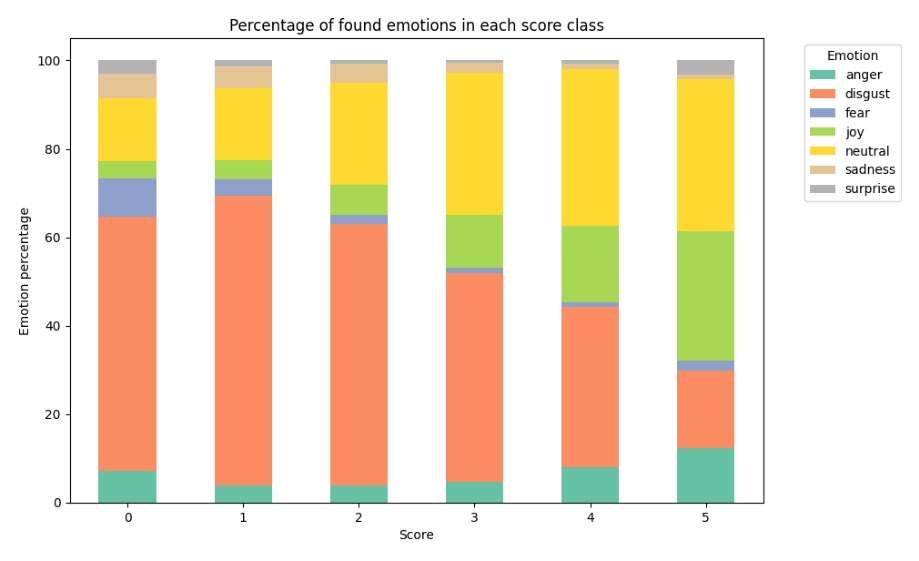

Spearman correlation for emotions by score: 
(if p value < 0.05 we can say that a change in score, introducted a predictable increase or decrease in the percentage for that emotion) 
          Spearman correlation   
anger                 0.600000  
disgust              -0.828571  
fear                 -0.657143  
joy                   1.000000  
neutral               0.942857  
sadness              -1.000000  
surprise              0.028571  



In [16]:
# plot_emotion_by_score_spearman(data)

fig, ax = plt.subplots(figsize=(10, 6))
img = mpimg.imread('graphs/emotions_by_class.png')
ax.imshow(img)
plt.tight_layout()
plt.axis('off')
plt.show()

with open("graphs/spearman_output.out", "r") as f:
    print(f.read())

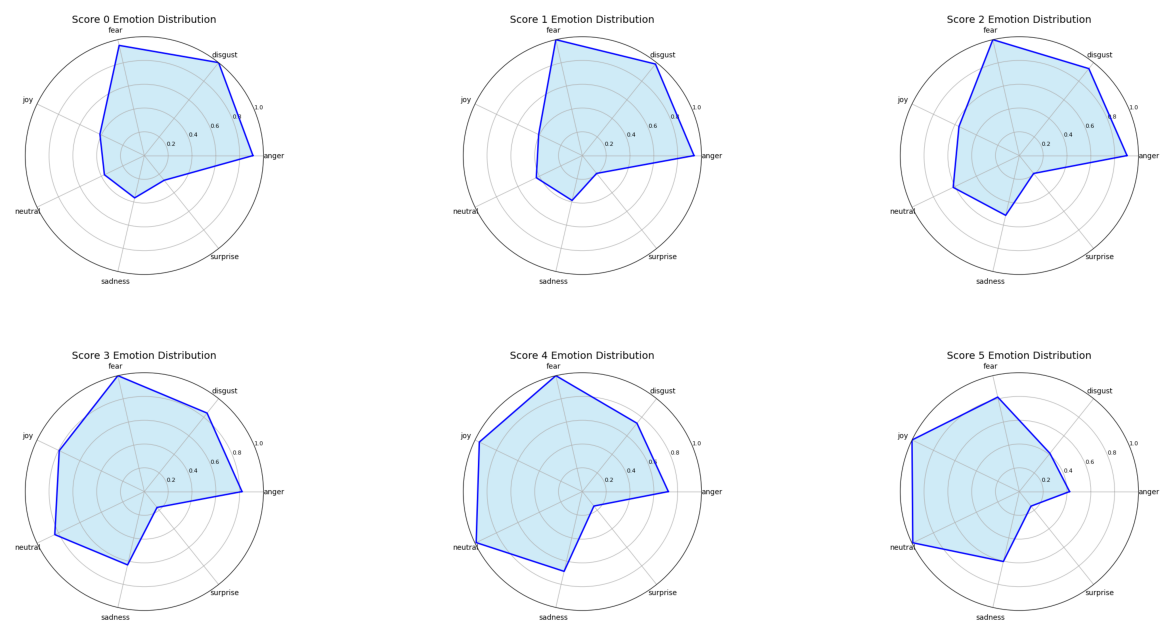

In [ ]:
# data = pd.read_pickle("lda_by_beer/results_lda.pkl")
# plot_score_emotions_distrib(data)

imgs = [mpimg.imread('graphs/radar_graph_emotions_by_score_0.png'),
        mpimg.imread('graphs/radar_graph_emotions_by_score_1.png'), 
        mpimg.imread('graphs/radar_graph_emotions_by_score_2.png'),
        mpimg.imread('graphs/radar_graph_emotions_by_score_3.png'),
        mpimg.imread('graphs/radar_graph_emotions_by_score_4.png'),
        mpimg.imread('graphs/radar_graph_emotions_by_score_5.png'),]
_, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.axis('off') 
    ax.imshow(img)
plt.show()

In [12]:
# much faster, we focus on the negative and positive parts

if not os.path.exists(processed_beers_csv):
    pos_corpus, neg_corpus, beer_names = build_corpus(reviews, emotion_split=True)

    tokenizer = Lemmatizer
    stop_words = get_stop_words([pos_doc + neg_doc for pos_doc, neg_doc in zip(pos_corpus, neg_corpus)], tokenizer=tokenizer)

    neg_counts = get_word_counts(neg_corpus, beer_names, tokenizer=tokenizer, stop_words=stop_words, min_df=0.02)
    pos_counts = get_word_counts(pos_corpus, beer_names, tokenizer=tokenizer, stop_words=stop_words, vocabulary=neg_counts.columns)

    scores = get_tfidf_scores(neg_counts) - get_tfidf_scores(pos_counts)
    top_criticisms_emotions = get_top_attributes(scores, column_prefix="crit_emot_", top_attributes=100)

    beers = beers.merge(top_criticisms_emotions.reset_index(), on="beer_name")
    beers.to_csv(processed_beers_csv, index=False)

## Following the clues : what drives negativity

#### Analysis of top criticisms by location, beer style, alcohol content

In [20]:
# beer subsets for visualization
locations = ["Belgium", "Brazil", "Croatia", "England", "Germany", "United States, Kentucky"]
styles = ["American Pale Ale", "American Strong Ale ", "Cream Ale", "Czech Pilsner (Světlý)", "Dunkelweizen", "Fruit Beer", "Imperial Porter"]

In [15]:
# attributes by location
top_attributes_by(beers, by="location", top_count=15, column_count=50).loc[locations]

,top_attr_1,top_attr_2,top_attr_3,top_attr_4,top_attr_5,top_attr_6,top_attr_7,top_attr_8,top_attr_9,top_attr_10,top_attr_11,top_attr_12,top_attr_13,top_attr_14,top_attr_15
location,,,,,,,,,,,,,,,
Belgium,belgian,golden,banana,yellow,gold,go,grape,cherry,peach,coriander,pear,berry,reddish,wood,beige
Brazil,corn,go,lager,south,vegetable,yellow,world,wheat,waitrose,unique,tick,thirst,tesco,systembolaget,syrup
Croatia,zagreb,lager,macro,pivo,country,croatia,hot,lcbo,metal,industrial,corny,eastern,euro,european,go
England,english,beige,golden,copper,roast,go,nut,cask,pint,nutty,reddish,chocolate,british,gold,burnt
Germany,go,golden,gold,yellow,wheat,straw,lager,refreshing,banana,beige,roast,wheaty,corn,munich,weizen
"United States, Kentucky",kentucky,go,draft,louisville,barrel,bourbon,age,copper,chocolate,char,burnt,beige,woody,wood,whiskey


In [16]:
# criticisms by location
top_attributes_by(beers, by="location", top_count=15, column_count=50, column_prefix="crit_").loc[locations]

,top_crit_1,top_crit_2,top_crit_3,top_crit_4,top_crit_5,top_crit_6,top_crit_7,top_crit_8,top_crit_9,top_crit_10,top_crit_11,top_crit_12,top_crit_13,top_crit_14,top_crit_15
location,,,,,,,,,,,,,,,
Belgium,alcoholic,artificial,acid,vinegar,yellow,sourish,syrup,blond,juice,weird,cider,belgian,wheat,metal,disappointing
Brazil,woman,waste,vegetable,adjunct,corn,bus,coca,cola,collins,coors,cross,deceive,department,dirty,distributor
Croatia,country,corny,awful,avoid,cardboard,generic,metal,recommend,pointless,plastic,longlasting,grand,hayish,headf,heineken
England,bland,skunk,cask,london,skunky,burnt,black,stale,lager,cardboard,poor,salty,disappointing,metal,stout
Germany,skunky,corn,bland,boring,skunk,yellow,wheaty,wheat,lager,cardboard,bore,disappointing,nasty,metal,stale
"United States, Kentucky",oak,licorice,stout,wow,whiskey,popcorn,seriously,drain,barrel,butter,black,cigarette,leather,lightish,locally


In [21]:
# combined criticisms of beer styles
top_attributes_by(beers, by="style", top_count=15, column_count=50, column_prefix=["crit_", "crit_emot_"]).loc[styles]

,top_crit_crit_emot_1,top_crit_crit_emot_2,top_crit_crit_emot_3,top_crit_crit_emot_4,top_crit_crit_emot_5,top_crit_crit_emot_6,top_crit_crit_emot_7,top_crit_crit_emot_8,top_crit_crit_emot_9,top_crit_crit_emot_10,top_crit_crit_emot_11,top_crit_crit_emot_12,top_crit_crit_emot_13,top_crit_crit_emot_14,top_crit_crit_emot_15
style,,,,,,,,,,,,,,,
American Pale Ale,perfume,peel,acid,rough,poor,pint,rocky,peach,pear,pungent,poured,ripe,pours,pine,pilsner
American Strong Ale,roast,plum,prune,rough,powerful,rotten,acid,peel,poor,peach,ruby,prickly,pint,salty,ripe
Cream Ale,perfume,peach,pale,overly,pepper,acid,pear,persistent,place,quality,peel,ripe,rotten,pick,pilsner
Czech Pilsner (Světlý),aroma,corn,bitter,pine,skunky,pale,taste,peach,pilsner,poor,skunk,sourness,smell,pint,perfume
Dunkelweizen,pours,murky,muddy,dark,aroma,color,brown,tan,smell,sour,mouthfeel,bitter,wheaty,nose,sourness
Fruit Beer,perfume,rotten,poor,peach,peel,acid,pours,ruby,puffy,plum,pub,pilsner,prickly,presence,powerful
Imperial Porter,salty,pitch,pours,roasty,roast,pine,ruby,roasted,poor,poured,plum,rough,prune,pungent,ring


In [22]:
# combined criticisms of beers
top_attributes_by(beers, by="beer_name", top_count=15, column_count=50, column_prefix=["crit_", "crit_emot_"]).head(2)

,top_crit_crit_emot_1,top_crit_crit_emot_2,top_crit_crit_emot_3,top_crit_crit_emot_4,top_crit_crit_emot_5,top_crit_crit_emot_6,top_crit_crit_emot_7,top_crit_crit_emot_8,top_crit_crit_emot_9,top_crit_crit_emot_10,top_crit_crit_emot_11,top_crit_crit_emot_12,top_crit_crit_emot_13,top_crit_crit_emot_14,top_crit_crit_emot_15
beer_name,,,,,,,,,,,,,,,
1795 Original Czech Lager (Budejovické Pivo),abound,opaque,pee,pear,peach,overwhelms,overpower,overly,open,old,oily,offwhite,number,noteworthy,nastiness
1809 Berliner Style Weisse,citric,zesty,yellow,write,wish,wet,warrant,unappealing,transparent,scent,rice,rbesg,raspberry,puffy,presence


#### Classifying common criticisms in different locations

In [100]:
location_features = top_attributes_by(beers, by="location", top_count=150, column_count=50, column_prefix=["crit_", "crit_emot_"])

In [102]:
location_features.head(5)

,location,top_crit_crit_emot_1,top_crit_crit_emot_2,top_crit_crit_emot_3,top_crit_crit_emot_4,top_crit_crit_emot_5,top_crit_crit_emot_6,top_crit_crit_emot_7,top_crit_crit_emot_8,top_crit_crit_emot_9,...,top_crit_crit_emot_141,top_crit_crit_emot_142,top_crit_crit_emot_143,top_crit_crit_emot_144,top_crit_crit_emot_145,top_crit_crit_emot_146,top_crit_crit_emot_147,top_crit_crit_emot_148,top_crit_crit_emot_149,top_crit_crit_emot_150
0,Argentina,poor,acid,adjuncty,alcohol,aroma,avoid,ball,belgian,bile,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,aroma,bad,pours,bitter,overpower,poor,peel,persistent,pitch,...,kerenmk,khaki,lager,leave,let,linger,local,lot,macro,mate
2,Austria,aroma,smell,bad,bitter,sour,mouthfeel,oily,yellow,sticky,...,wheat,yellowy,acid,acidic,activity,adhesive,alco,arm,artificial,awful
3,Bahamas,abomination,acid,aluminum,as,avoid,biter,blah,bonus,btl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Barbados,aforementioned,aroma,award,barley,beach,bitter,bottle,breakfast,budweiser,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

classified_criticisms_by_location_csv = processed_directory + "classified_criticisms_by_location.csv"

if os.path.exists(classified_criticisms_by_location_csv):
    classified_criticisms_by_location = pd.read_csv(classified_criticisms_by_location_csv)
else:
    classified_criticisms_by_location = classify_beer_attributes(criticisms = location_features, device = "cuda", by = 'location')
    classified_criticisms_by_location.to_csv(classified_criticisms_by_location_csv)



100%|█████████████████████████████████████████████████████████████| 117/117 [24:23<00:00, 12.51s/it]


In [121]:
classified_criticisms_by_location.head(3)

,appearance,aroma,palate,taste
location,,,,
Argentina,"[football, opaque, presence, present, rotten, ...","[aroma, oily, perfume, pungent, ripe, roasted]","[alcohol, crap, foul, history, pine, plenty, p...","[budweiser, fizz, pepper, pick, pilsner, rice,..."
Australia,"[faint, head, come, muddy, opaque, present, pr...","[aroma, perfume, roasted, oily, smell, ripe, s...","[mouth, palate, crap, plenty, plum, poured, dr...","[bitter, mouthfeel, pepper, pick, bitterness, ..."
Austria,"[faint, presence, darker, present, reddish, ro...","[aroma, smell, oily, scent, perfume, vinous, a...","[alcohol, mouth, pale, palate, sipper, white, ...","[bitter, sour, mouthfeel, feel, malt, sourness..."


#### Classifying combined criticsms of different beer styles

In [124]:
style_criticisms = top_attributes_by(beers, by="style", top_count=150, column_count=50, column_prefix=["crit_", 'crit_emot_'])

In [129]:
style_criticisms.head(5)

,style,top_crit_crit_emot_1,top_crit_crit_emot_2,top_crit_crit_emot_3,top_crit_crit_emot_4,top_crit_crit_emot_5,top_crit_crit_emot_6,top_crit_crit_emot_7,top_crit_crit_emot_8,top_crit_crit_emot_9,...,top_crit_crit_emot_141,top_crit_crit_emot_142,top_crit_crit_emot_143,top_crit_crit_emot_144,top_crit_crit_emot_145,top_crit_crit_emot_146,top_crit_crit_emot_147,top_crit_crit_emot_148,top_crit_crit_emot_149,top_crit_crit_emot_150
0,Abbey Dubbel,pear,pours,rocky,rotten,acid,poor,prune,roast,roasted,...,fruitcake,funky,gift,grape,heavy,holiday,inside,ita,lager,large
1,Abbey Tripel,pear,peach,poor,pours,perfume,ripe,pilsner,persistent,powerful,...,cheddar,chimay,chunk,cloudy,coarse,corked,corriander,den,ester,feel
2,Abt/Quadrupel,pours,ripe,pear,present,roast,roasted,salty,acid,peel,...,ruin,scent,score,sipper,small,strongly,age,aging,alc,alcholic
3,Altbier,pours,puffy,bitter,dark,pine,aroma,overly,pear,pungent,...,cereal,compact,copper,cough,couldve,delivery,dense,despite,detect,dfh
4,Amber Ale,pint,pours,roasty,perfume,poor,puffy,rotten,rough,pear,...,business,buttery,caramelize,care,carrot,closer,coast,cocktail,collins,combination


In [ ]:

classified_criticisms_by_style_csv = processed_directory + "classified_criticisms_by_style.csv"

if os.path.exists(classified_criticisms_by_style_csv):
    classified_criticisms_by_style = pd.read_csv(classified_criticisms_by_style_csv)
    
else:
    classified_criticisms_by_style = classify_beer_attributes(criticisms = style_criticisms, device = "cuda", by = 'style')
    classified_criticisms_by_style.to_csv(classified_criticisms_by_style_csv)
    


100%|███████████████████████████████████████████████████████████████| 79/79 [16:12<00:00, 12.31s/it]


In [133]:
classified_criticisms_by_style.head(3)

,appearance,aroma,palate,taste
style,,,,
Abbey Dubbel,"[rotten, prune, presence, present, pretty, pro...","[roasted, ripe, perfume, pungent, bubblegum, a...","[plenty, plum, poured, palate, pale, pine, bla...","[pepper, pick, pilsner, pleasant, quality, sal..."
Abbey Tripel,"[present, prune, puffy, rotten, presence, pret...","[perfume, ripe, pungent, roasted, bubblegum, a...","[pale, pine, poured, palate, plenty, plum, alc...","[pilsner, salty, pepper, pick, pleasant, quali..."
Abt/Quadrupel,"[present, presence, prune, rotten, pretty, pro...","[ripe, roasted, pungent, perfume, bubblegum, a...","[plum, poured, palate, pale, pine, plenty, cou...","[salty, pepper, pick, pilsner, pleasant, quali..."


#### Some examples of complaints derived from emotion analysis

In [138]:
tokens_feeling = pd.read_csv("./data/reviews_with_tokens_emotions.csv")
tokens_feeling[tokens_feeling["anger"] > 0.5]
tokens_feeling["emotional_sum"] = tokens_feeling["anger"] + tokens_feeling["disgust"] + tokens_feeling["fear"]
sorted_tokens = tokens_feeling.sort_values(by="emotional_sum", ascending=False)
tokens_feeling = tokens_feeling.drop(columns=["emotional_sum"])

In [141]:
sorted_tokens["review"].tolist()[20:40]

[' i am very scary and dangerous',
 ' so i was very nervous to taste this',
 'i was scared when i looked at the bottle',
 ' and pint served showing a clear & fright',
 ' im quite scared how much i like this ',
 '  I would not hesitate to drink this beer again',
 ' pout from the bottle is clear and Amber ',
 ' I was apprehensive about the thyme',
 'Angry and aggressive beer upon pouring',
 ' I was apprehensive at first to try a beer with a drunken cartoon dog on the label but its a local brewery so i said what the hell',
 '  I hesitate to say it',
 'Tart (dur) and not overly peachy as i was frightful of',
 '  I would not hesitate to buy this again',
 'Sampled at a beer tasting party',
 ' I was scared at the time',
 'did in a side by side with the dreadnaught',
 'I would like to take the opportunity to thank Youngs Brewery of Wandsworth England for producing such disgusting beer',
 ' and a mildly abrasive feeling',
 ' was at first scared',
 '  I always feel uneasy rating something I have